# Project Goals
## Overview

Using data collected from MIT, can we predict if a patient will survive a trip to the ICU based on the condition recorded for the patient. To answer this, we'll be using classification machine learning algorithms to develop our models, and test if we're outperforming the model used in hospitals today.

# The Data: First Look

Let's get our data into a dataframe to examin it:

In [1]:
import src.wrangle
import src.explore
import src.preprocessing
import src.features

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

df = src.wrangle.get_raw_data()
data_dict = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')

df.head()

encounter_id  hospital_id  hospital_death   age    bmi  \
patient_id                                                           
25312              66154          118               0  68.0  22.73   
59342             114252           81               0  77.0  27.42   
50777             119783          118               0  25.0  31.95   
46918              79267          118               0  81.0  22.64   
34377              92056           33               0  19.0    NaN   

            elective_surgery  ethnicity gender  height hospital_admit_source  \
patient_id                                                                     
25312                      0  Caucasian      M   180.3                 Floor   
59342                      0  Caucasian      F   160.0                 Floor   
50777                      0  Caucasian      F   172.7  Emergency Department   
46918                      1  Caucasian      F   165.1        Operating Room   
34377                      0  Caucasian      M   188.0                   NaN   

            ... aids  cirrhosis diabetes_mellitus hepatic_failure  \
patient_id  ...                                                     
25312       ...  0.0        0.0               1.0             0.0   
59342       ...  0.0        0.0               1.0             0.0   
50777       ...  0.0        0.0               0.0             0.0   
46918       ...  0.0        0.0               0.0             0.0   
34377       ...  0.0        0.0               0.0             0.0   

            immunosuppression  leukemia  lymphoma  \
patient_id                                          
25312                     0.0       0.0       0.0   
59342                     0.0       0.0       0.0   
50777                     0.0       0.0       0.0   
46918                     0.0       0.0       0.0   
34377                     0.0       0.0       0.0   

            solid_tumor_with_metastasis  apache_3j_bodysystem  \
patient_id                                                      
25312                               0.0                Sepsis   
59342                               0.0           Respiratory   
50777                               0.0             Metabolic   
46918                               0.0        Cardiovascular   
34377                               0.0                Trauma   

            apache_2_bodysystem  
patient_id                       
25312            Cardiovascular  
59342               Respiratory  
50777                 Metabolic  
46918            Cardiovascular  
34377                    Trauma  

[5 rows x 185 columns]

## Size of the Raw Data

In [2]:
print(f'''Number of Columns: {df.shape[1]}, Number of Rows: {df.shape[0]}''')

Number of Columns: 185, Number of Rows: 91713


> This means that we have *91,713* patients in our dataset, with *185* metrics recorded for each of them within that 24 hour period. That's quite a bit of data.

## Number of Hospitals

In [3]:
print(f'Number of hospitals: {df.hospital_id.nunique()}')

Number of hospitals: 147


## Imbalanced Data

Our goal for this project is to predict patient survivability, so what does that distribution look like in our data?

In [4]:
num_patients_died = len(df[df.hospital_death == 1])
print('Percentage of patients who did not survive: {: .2f}'.format(num_patients_died / len(df)))

Percentage of patients who did not survive:  0.09


>*91* percent of the patients survived their time in the ICU, while only *9* percent did not. 

While this is great news in terms of ICU survival rates, it means we're dealing with an imbalanced dataset which is going to raise its own challenges as we move forward.

## Quick Look at the Missing Values

We'll be using a library called [missingno]('https://github.com/ResidentMario/missingno') to visualize the missing values within the data.

demographic


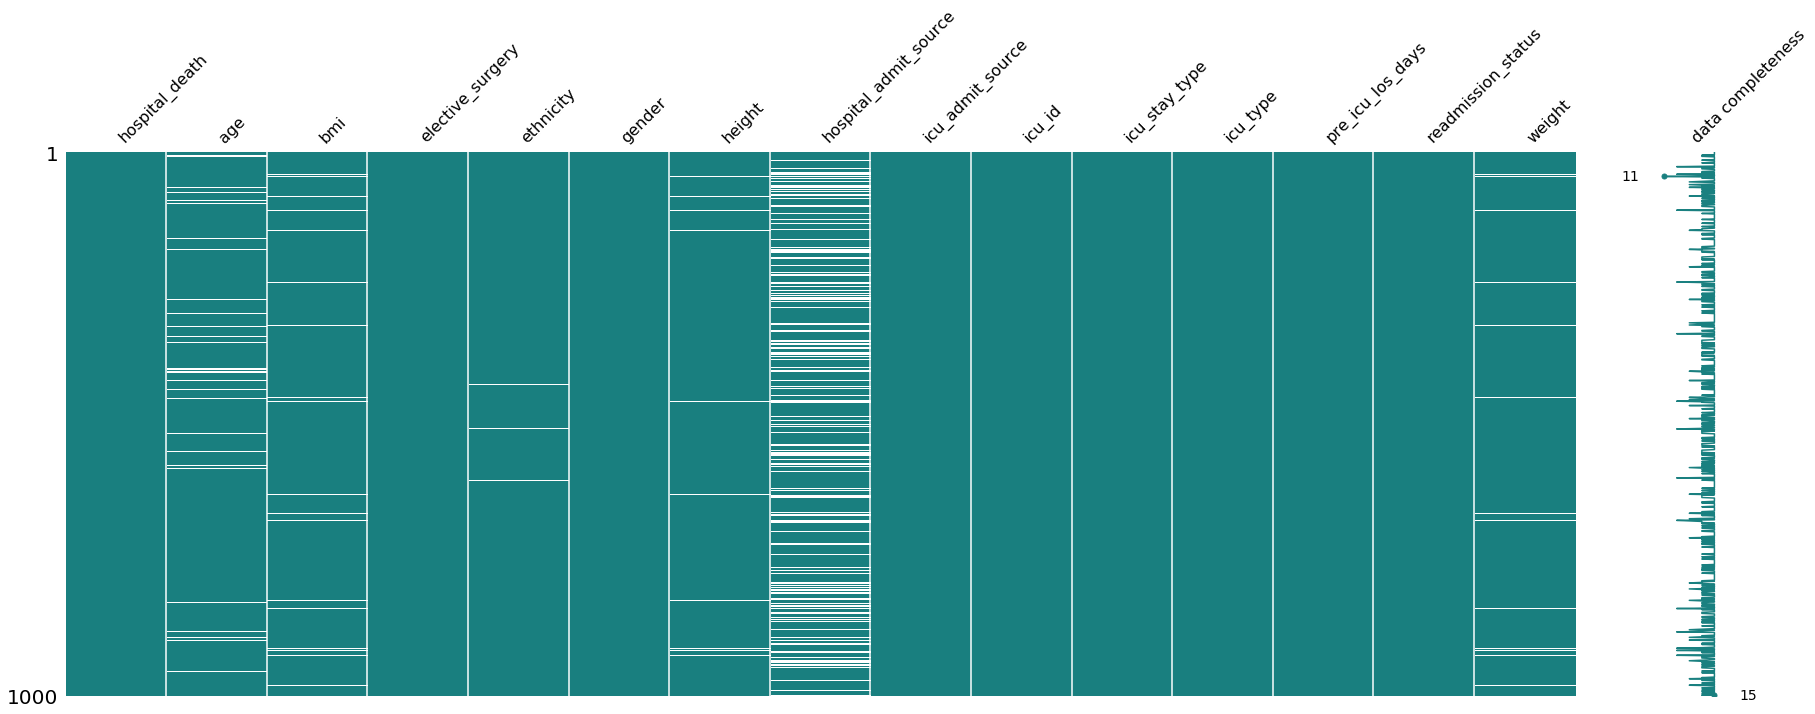

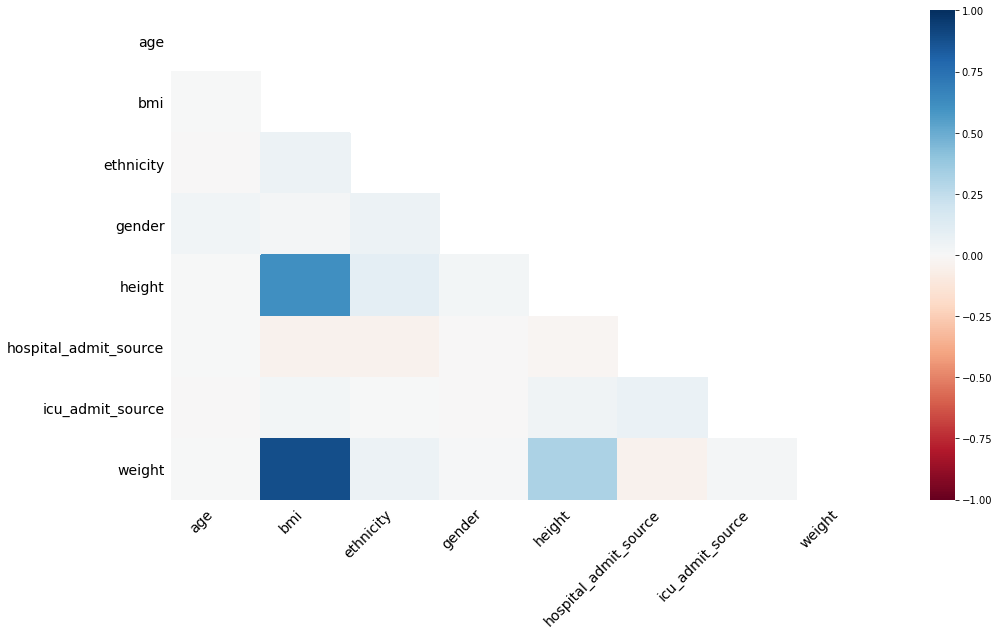

APACHE covariate


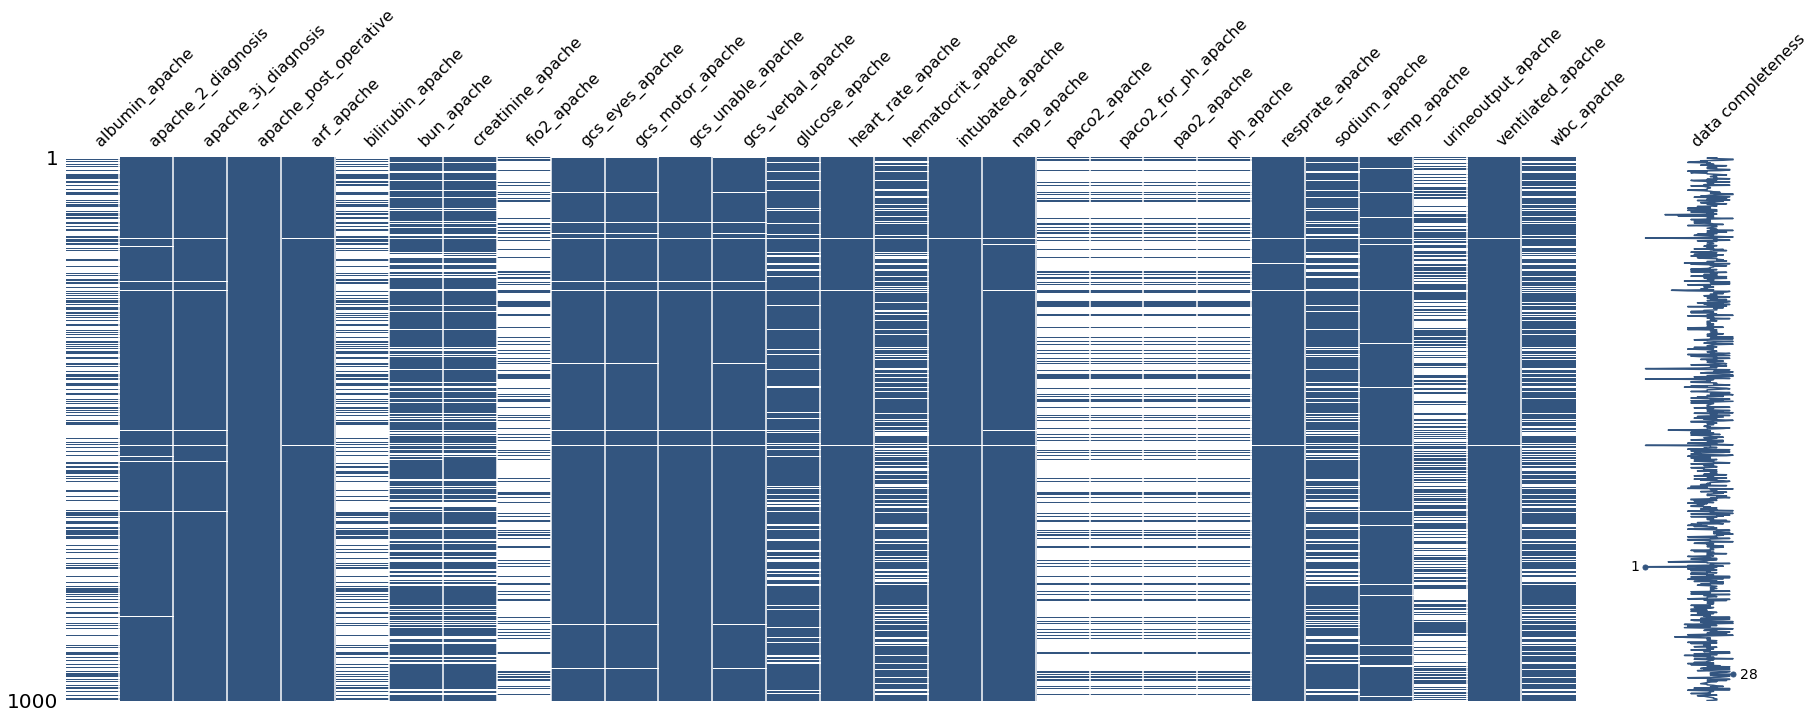

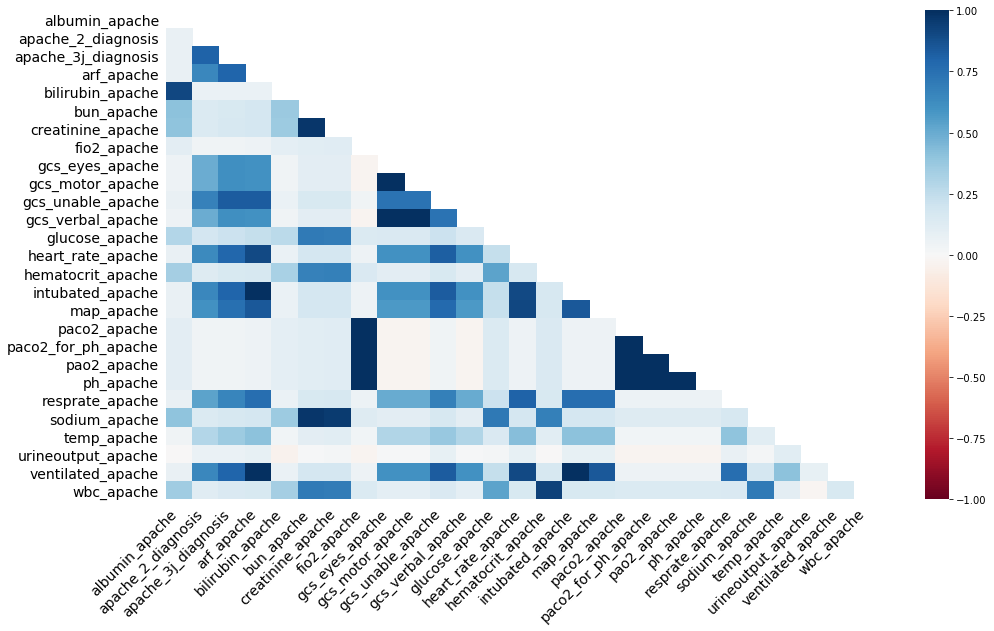

vitals


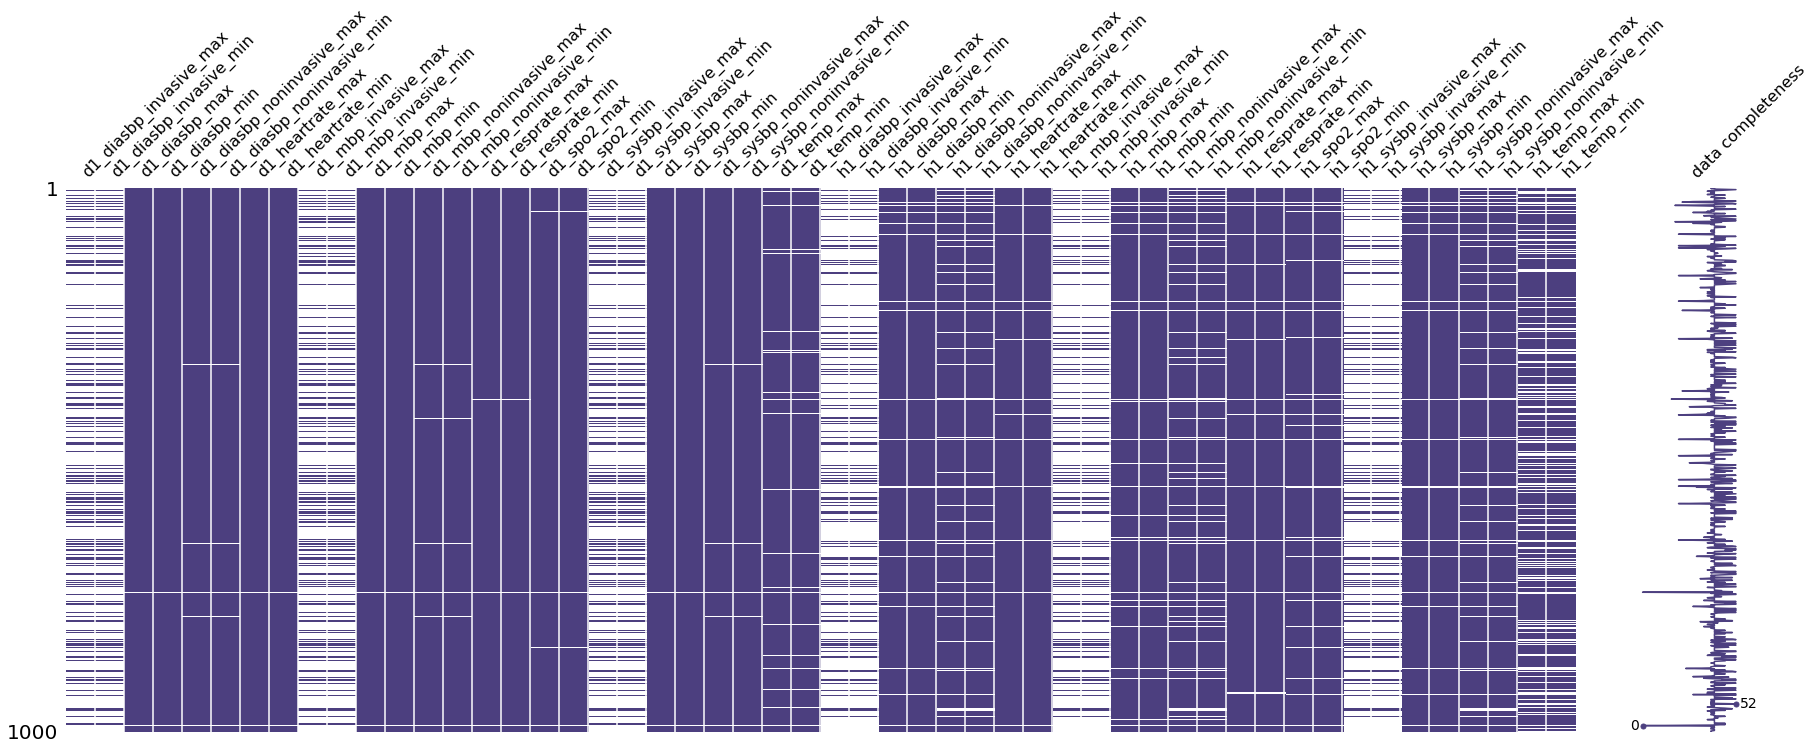

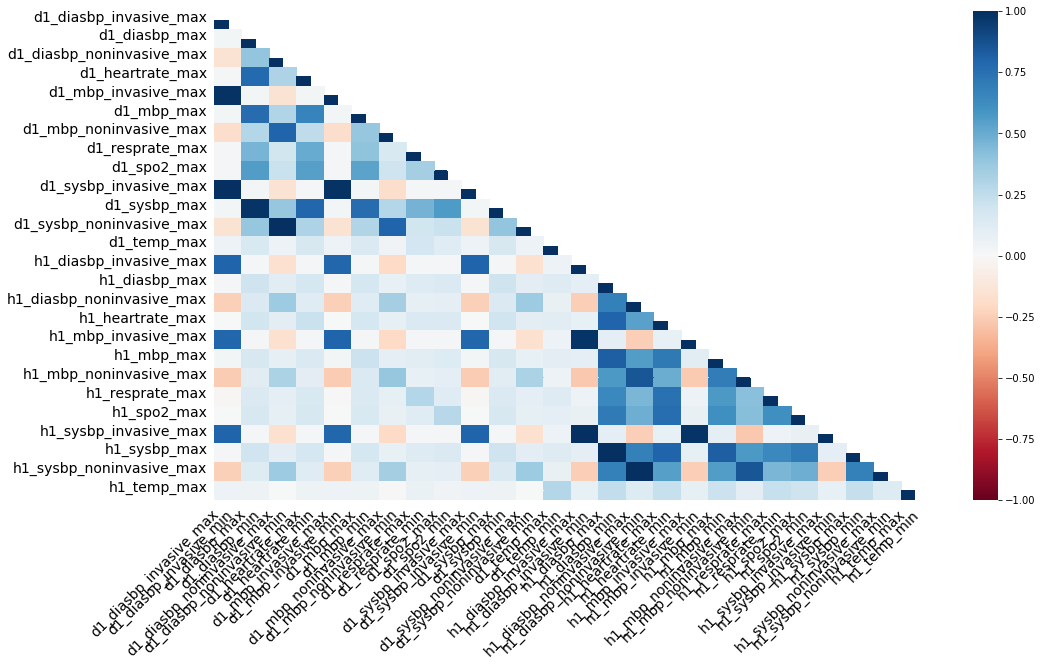

labs


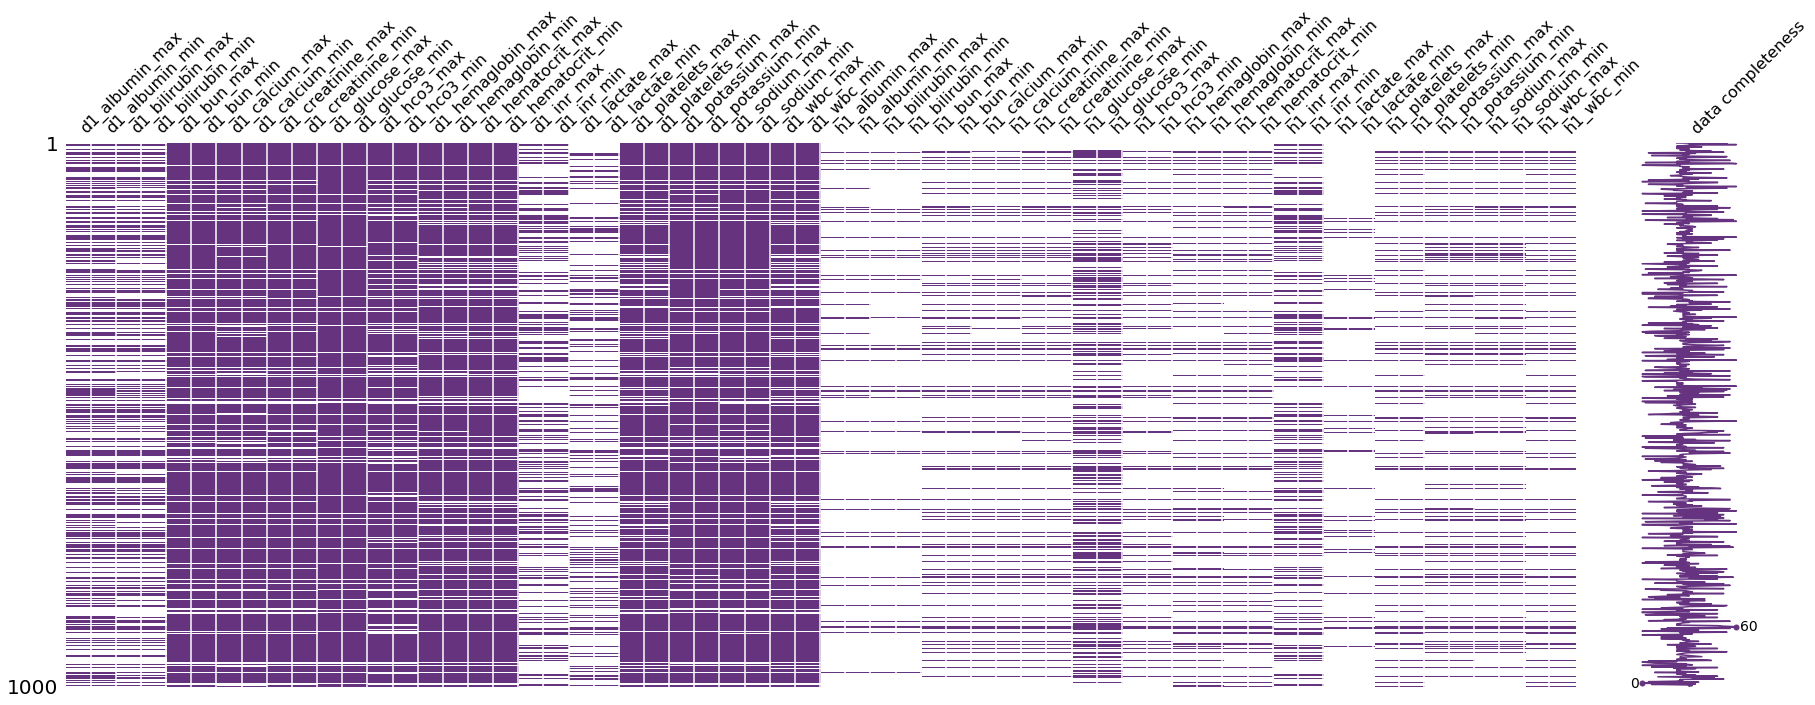

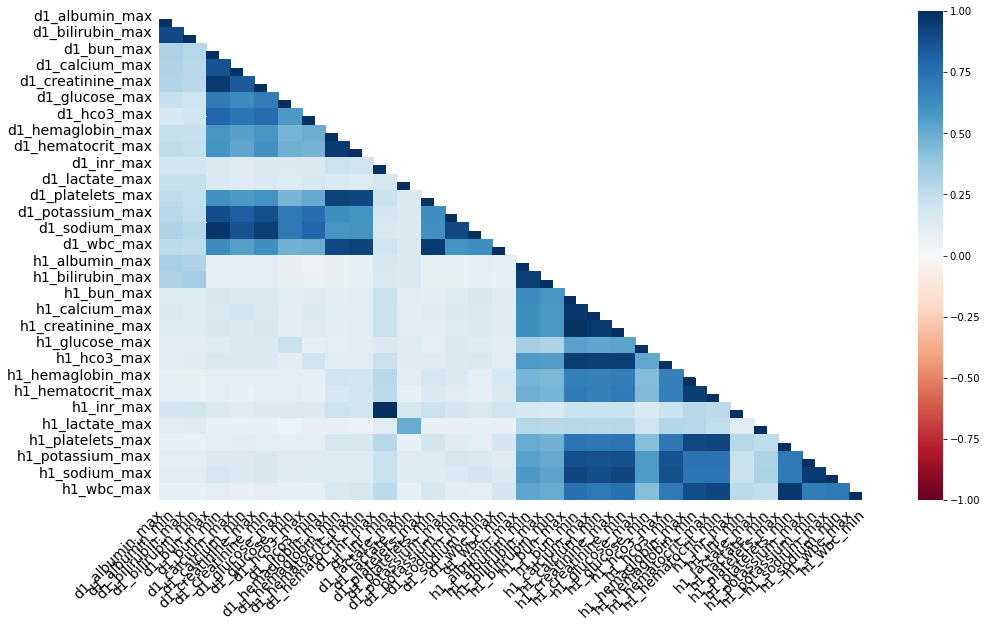

labs blood gas


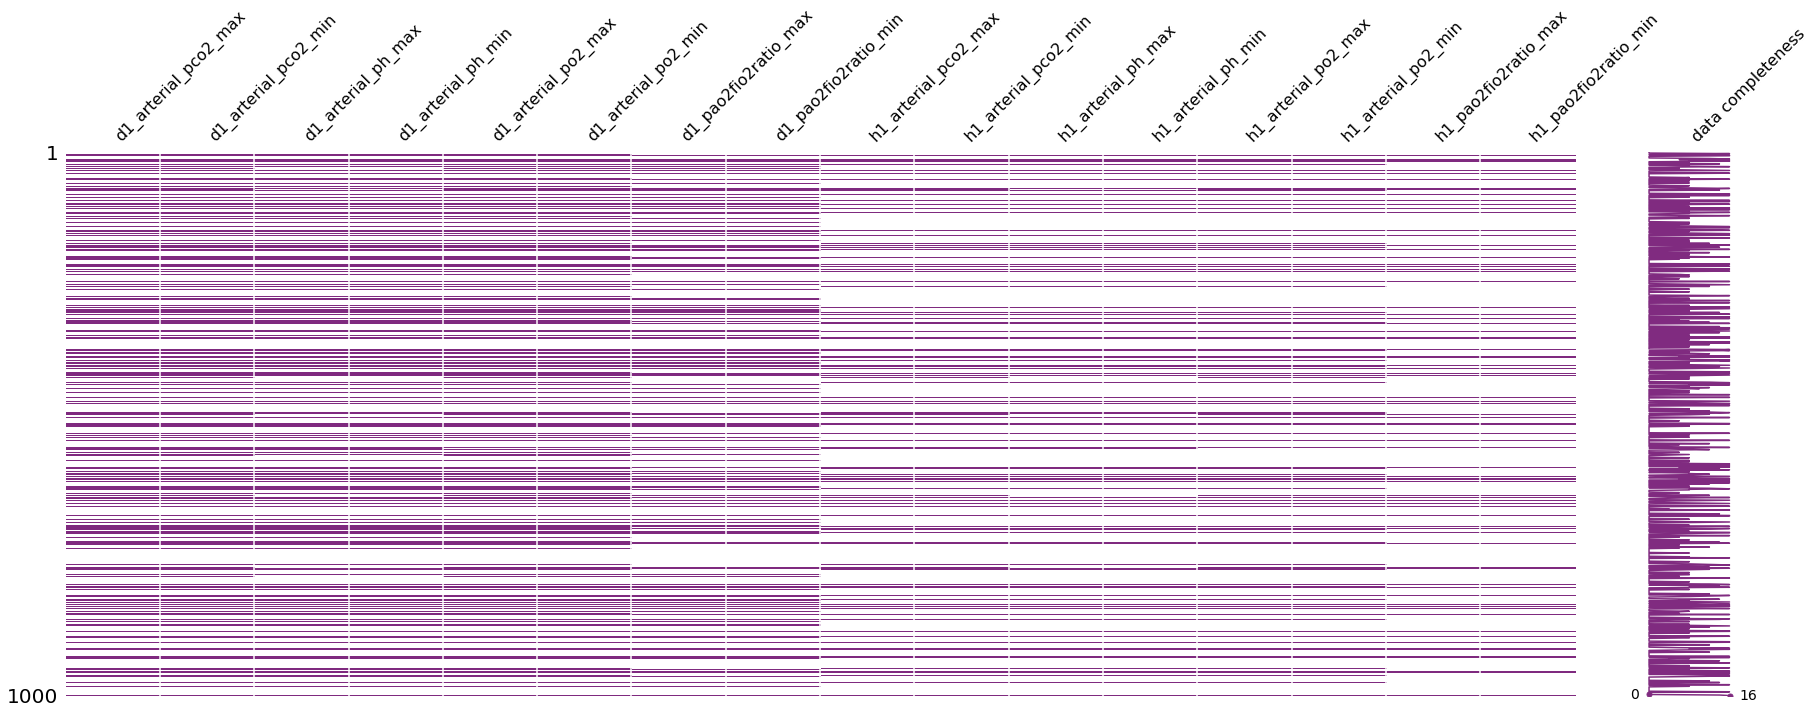

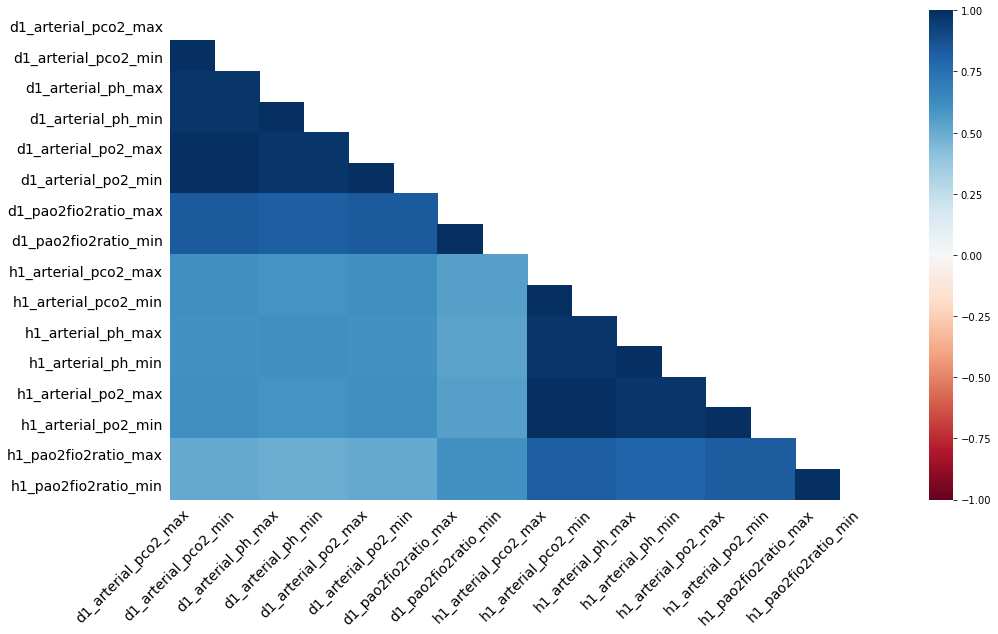

APACHE prediction


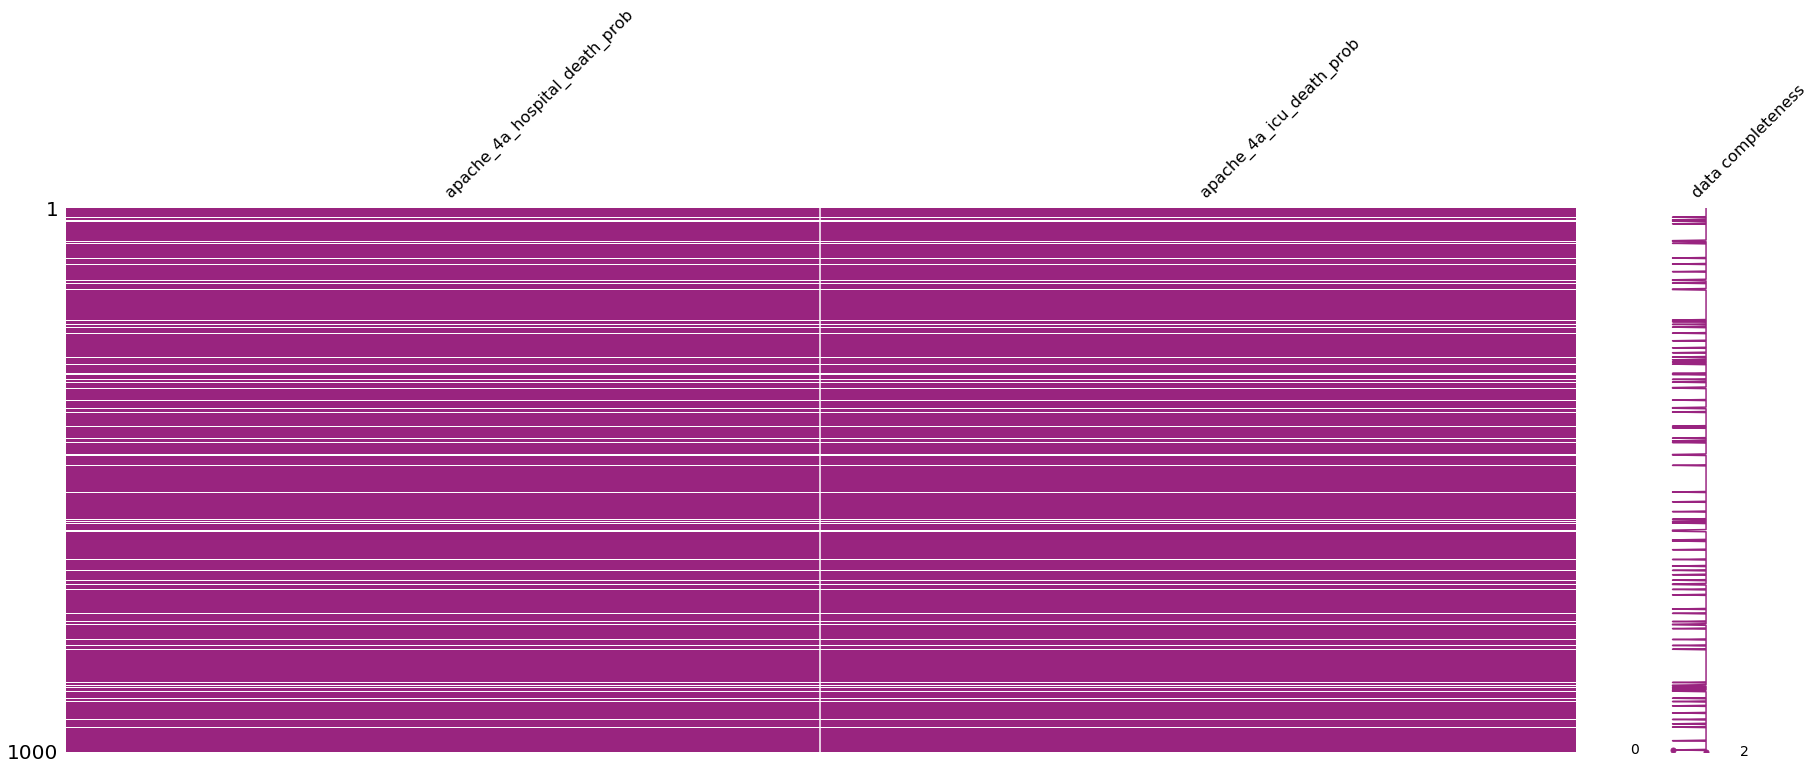

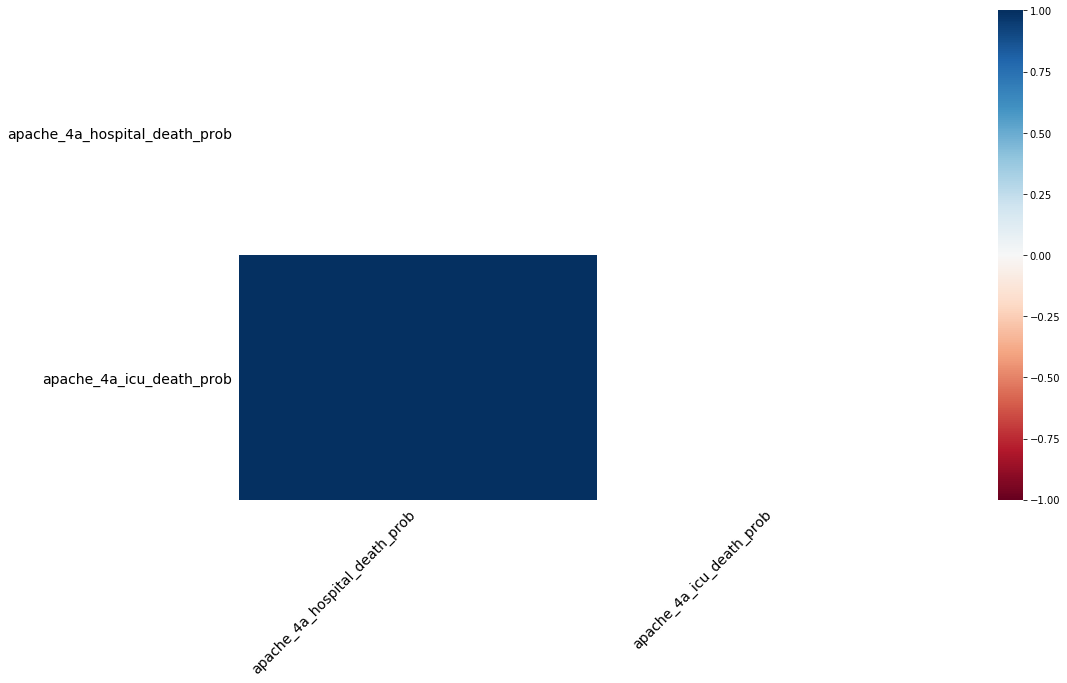

APACHE comorbidity


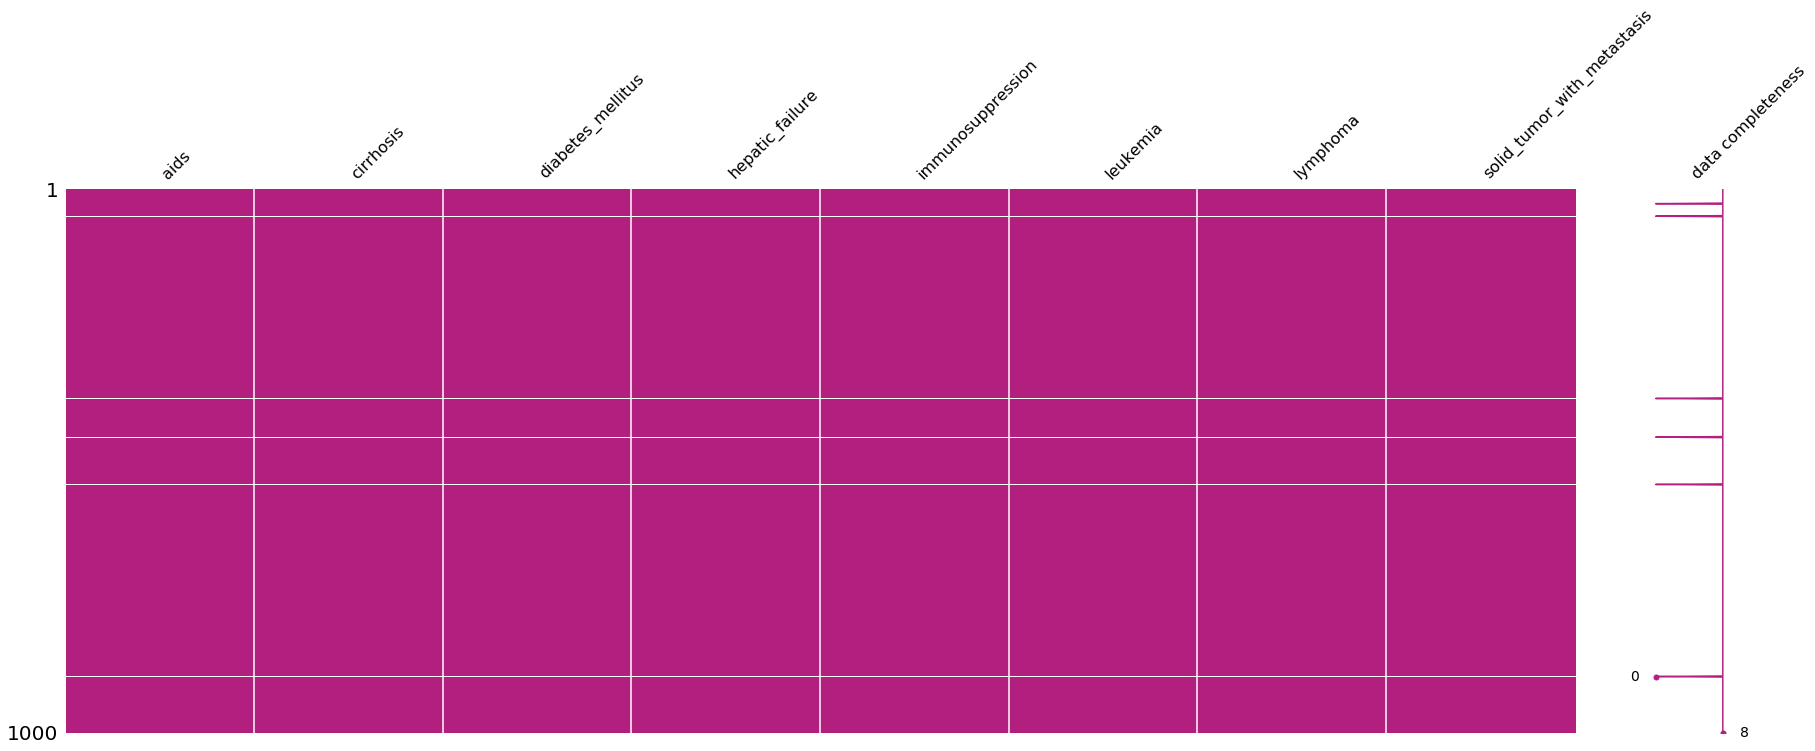

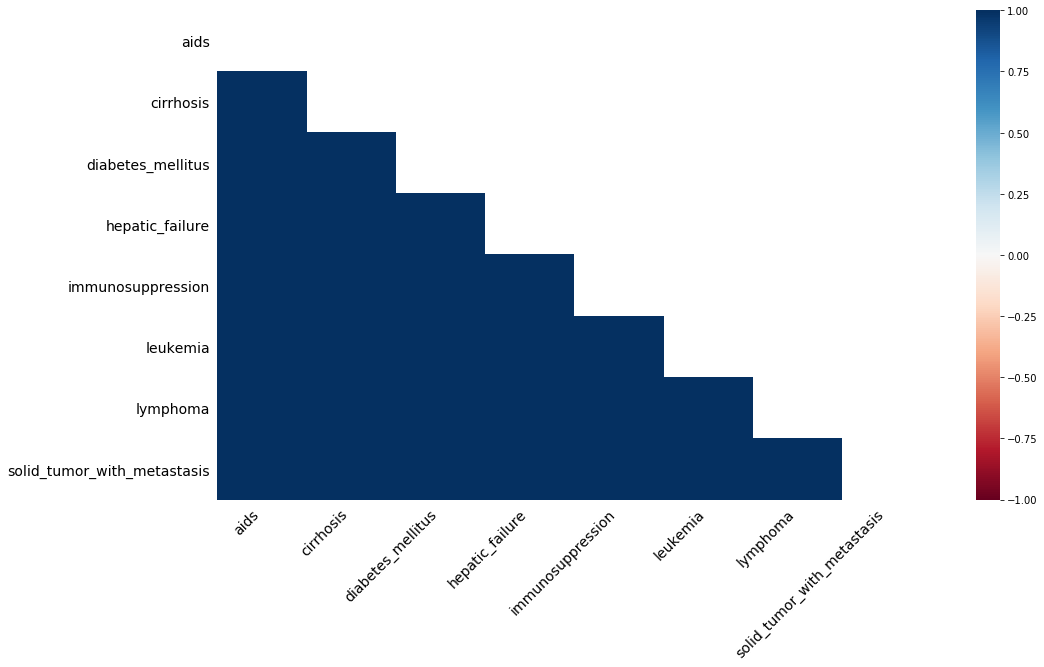

APACHE grouping


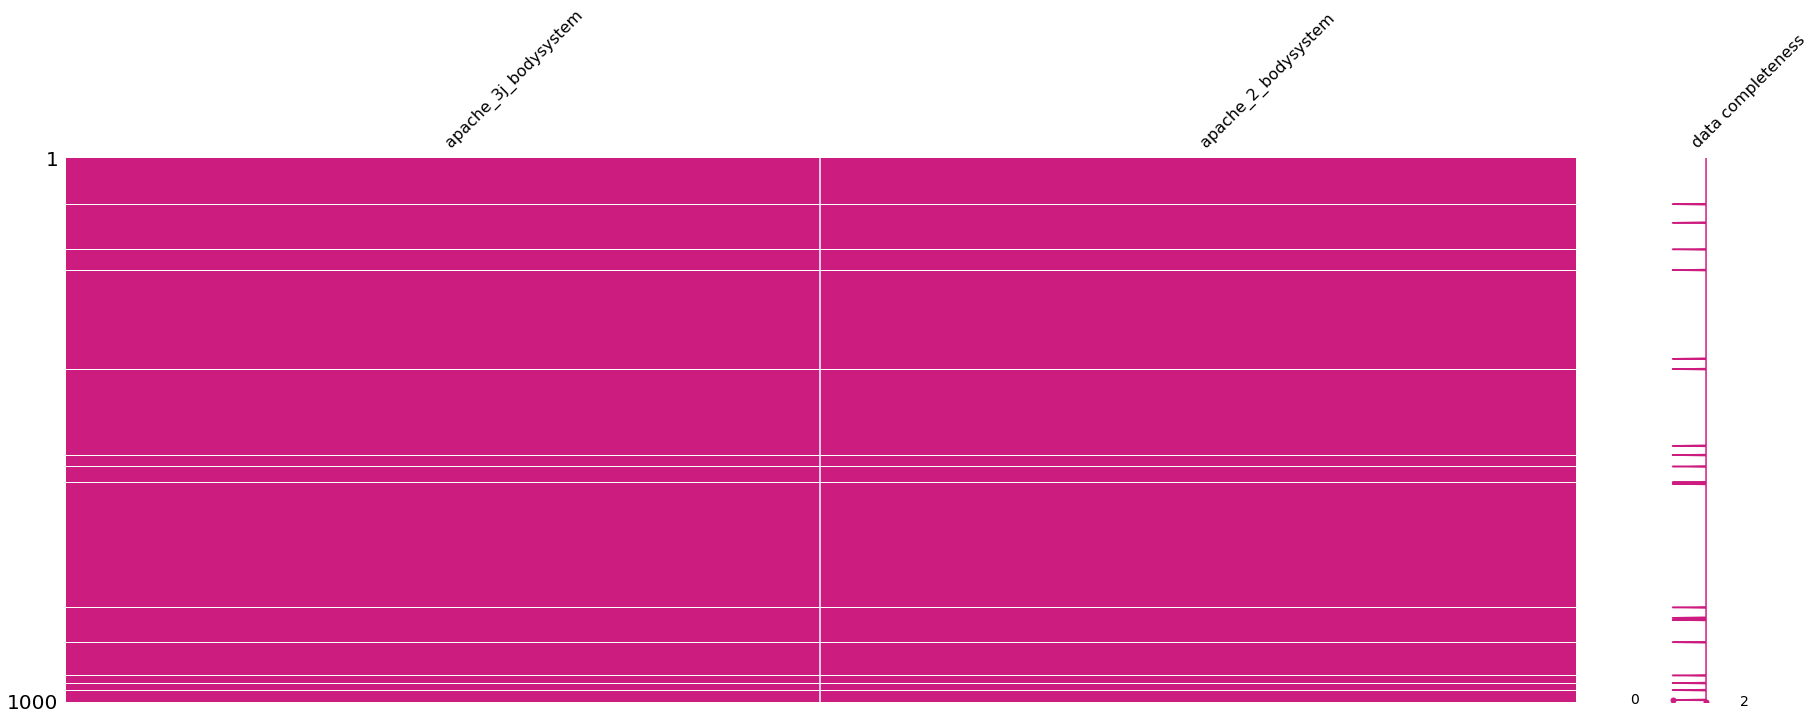

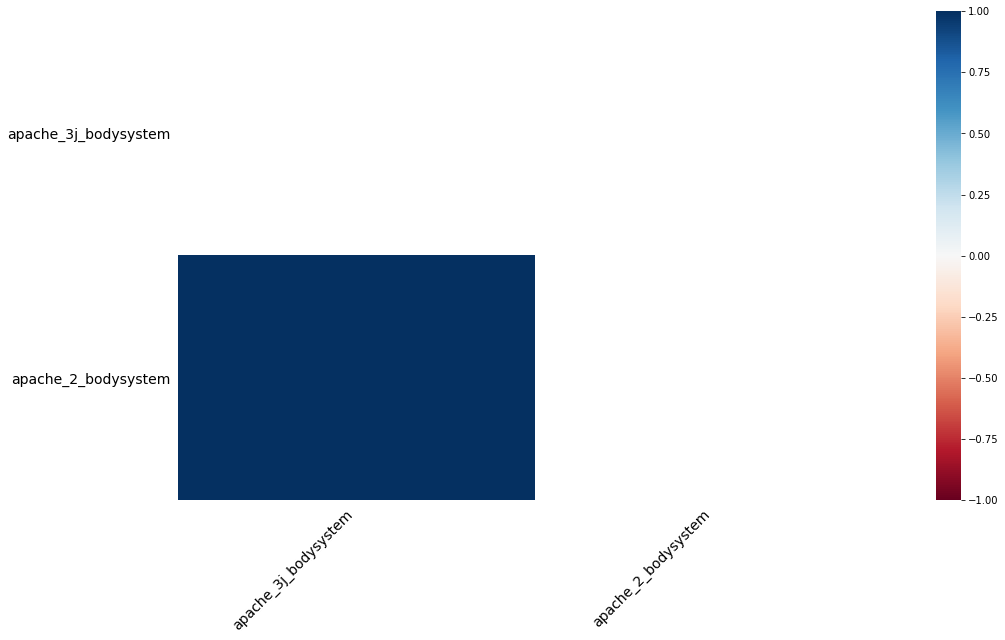

In [5]:
import missingno as msno
import matplotlib.pyplot as plt

for color, variable in enumerate(data_dict["Category"].unique()):
    if variable not in ["GOSSIS example prediction", "identifier"]:
        print(variable)
        column_list = data_dict[data_dict["Category"] == variable]["Variable Name"].values.tolist()
        column_list = [f for f in column_list if f in df.columns]
        if len(column_list) > 0:
            msno.matrix(
                df[column_list].sample(1000),
                figsize=(30, 10),
                labels=True,
                color=(color / 10, 1 / (color + 1), 0.5),
                fontsize=16,
            )
            msno.heatmap(
                df[column_list], figsize=(16, 9), labels=False, fontsize=14
            )
            plt.show()

# Preparation: Challenges Faced and How We Handled Them

## Null Values: A Different Beast in an Imbalanced Data Set
Since our target value (patient survivability) we're attempting to predict is imbalanced in our dataset, this affects our ability to handle nulls through blanket fixes. What we'll have to do is correlate the significance of the missing values against our target value to identify if the missing values are actually playing a role in patient survivability. 

> Below, we've run through each feature in our dataset to identify if the feature is dependent or independent of hospital_death. 

In [6]:
src.explore.significance_testing_of_nulls(df)

(encounter_id and hospital_death) are  independent of each other. (p = 0.4984475106646044)
(hospital_id and hospital_death) are  dependent of each other. (p = 3.971188907548724e-148)
(hospital_death and hospital_death) are  dependent of each other. (p = 0.0)
(age and hospital_death) are  dependent of each other. (p = 4.3986226670688454e-204)
(bmi and hospital_death) are  independent of each other. (p = 0.10323036630688469)
(elective_surgery and hospital_death) are  dependent of each other. (p = 1.8111023373323387e-176)
(ethnicity and hospital_death) are  dependent of each other. (p = 0.0031164745025517304)
(gender and hospital_death) are  dependent of each other. (p = 0.03441709366041668)
(height and hospital_death) are  dependent of each other. (p = 0.0021710052871524873)
(hospital_admit_source and hospital_death) are  dependent of each other. (p = 1.2519350471326363e-197)
(icu_admit_source and hospital_death) are  dependent of each other. (p = 3.7031521455538844e-243)
(icu_id and hos

What do we get from this? This helped us identify the features which were independent of our target variable, and much more useful for our models than the other features. 

## Splitting the Data for Exploration

Now that we've taken a look at the data in broad strokes, it's time to split it so we're not spoiling our test data.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train, test = train_test_split(
    df, train_size=0.8, random_state=42, stratify=df.hospital_death
)

## Applying Wrangle to the Split Data

In [9]:
for df in [train, test]:
    df.pipe(src.wrangle.prepare_data)

In [10]:
# Making sure there's no missing data in the train or test
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

In [11]:
# Looking at how the data was split
train.shape, test.shape

((73370, 185), (18343, 185))

# Exploration: Examining Which Factors are Affecting Patient Survival

## Average Hospital Death Probability by Gender

In [12]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots

In [13]:
female_age_death = (
    train[train["gender"] == "F"][["age", "hospital_death"]]
    .groupby("age")
    .mean()
    .reset_index()
)

In [14]:
male_age_death = (
    train[train["gender"] == "M"][["age", "hospital_death"]]
    .groupby("age")
    .mean()
    .reset_index()
)

In [15]:
fig = make_subplots()
fig.add_trace(
    go.Scatter(
        x=female_age_death["age"], y=female_age_death["hospital_death"], name="Female patients"
    )
)
fig.add_trace(
    go.Scatter(
        x=male_age_death["age"], y=male_age_death["hospital_death"], name="Male patients"
    )
)
fig.update_layout(title_text="<b>Average Hospital Death Probability By Gender<b>")
fig.update_xaxes(title_text="<b>Patient Age<b>")
fig.update_yaxes(title_text="<b>Average Hospital Death</b>", secondary_y=False)
fig.show()

# Uncomment this code to create the HTML file to embed chart
#pio.write_html(fig, file='index.html', auto_open=True)

## Does the Amount of Time in the ICU Affect Survival Rate?

In [16]:
ICU_type = train[["icu_type", "age", "hospital_death"]]

In [17]:
ICU_day = train[train["pre_icu_los_days"] >= 0][
    ["icu_type", "pre_icu_los_days", "hospital_death"]
]
ICU_day["icu_type"] = ICU_type["icu_type"].replace(
    {
        "MICU": "Medical ICU",
        "Neuro ICU": "Neurology ICU",
        "CCU-CTICU": "Cardiothoracic ICU",
        "CTICU": "Cardiothoracic ICU",
        "SICU": "Surgical ICU ",
        "CSICU": "Cardiac Surgery ICU",
        "Med-Surg ICU": "Medical Surgical ICU"
    }
)
ICU_day["pre_icu_los_days"] = ICU_day["pre_icu_los_days"].round(0)
ICU_df = ICU_day.groupby(["icu_type", "pre_icu_los_days"]).mean().reset_index()
ICU_df["count"] = (
    ICU_day.groupby(["icu_type", "pre_icu_los_days"])
    .sum()
    .reset_index()["hospital_death"]
)

fig = px.scatter(
    ICU_df,
    x="pre_icu_los_days",
    y="hospital_death",
    size="count",
    color="icu_type",
    hover_name="icu_type",
    log_x=True,
    size_max=200,
)

fig.update_layout(legend_title_text='ICU Type')
fig.update_layout(
    title_text="<b>Survival rate at different length of stay before ICU admission<b>"
)
fig.update_yaxes(title_text="<b>Average Hospital Death<b>")
fig.update_xaxes(
    title_text="<b>The length of stay of the patient between hospital admission and unit admission <b>"
)
fig.show()

# Uncomment this code to create the HTML file to embed chart
#pio.write_html(fig, file='index.html', auto_open=True)

## Does the Type of ICU affect Survival Chances?

In [18]:
ICU_type["icu_type"] = ICU_type["icu_type"].replace(
    {
        "Med-Surg ICU": "Medical Surgical ICU",
        "MICU": "Medical ICU",
        "Neuro ICU": "Neurology ICU",
        "CCU-CTICU": "Cardiothoracic ICU",
        "CTICU": "Cardiothoracic ICU",
        "SICU": "Surgical ICU ",
        "CSICU": "Cardiac Surgery ICU",
    }
)

In [19]:
ICU_df = ICU_type.groupby(["icu_type", "age"]).mean().reset_index()
ICU_df["count"] = (
    ICU_type.groupby(["icu_type", "age"]).count().reset_index()["hospital_death"]
)

In [20]:
fig = px.scatter(
    ICU_df,
    x="age",
    y="hospital_death",
    size="count",
    color="icu_type",
    hover_name="icu_type",
    log_x=False,
    size_max=40,
)

fig.update_layout(legend_title_text='ICU Type')
fig.update_layout(title_text="<b>Survival rate at different types of ICU<b>")
fig.update_yaxes(title_text="<b>Average Hospital Death<b>")
fig.update_xaxes(title_text="<b>Age<b>")
fig.show()

# Uncomment this code to create the HTML file to embed chart
#pio.write_html(fig, file='index.html', auto_open=True)

## How Much Does the Age of the Patient Affect Survival?

In [21]:
apache3=train[['age','apache_3j_bodysystem','hospital_death']]
apache3=apache3.groupby(['apache_3j_bodysystem','age']).agg(['size','mean']).reset_index()

apache3['size']=apache3['hospital_death']['size']
apache3['mean']=apache3['hospital_death']['mean']

apache3.drop('hospital_death',axis=1,inplace=True)

systems = apache3['apache_3j_bodysystem'].unique().tolist()
data = []
list_updatemenus = []
for n, s in enumerate(systems):
    visible = [False] * len(systems)
    visible[n] = True
    temp_dict = dict(label = str(s),
                 method = 'update',
                 args = [{'visible': visible},
                         {'title': '<b>'+s+'<b>'}])
    list_updatemenus.append(temp_dict)
    

for s in systems:
    mask = (apache3['apache_3j_bodysystem'].values == s) 
    trace = (dict(visible = False,     
        x = apache3.loc[mask, 'age'],
        y = apache3.loc[mask, 'mean'],
        mode = 'markers',
        marker = {'size':apache3.loc[mask, 'size']/apache3.loc[mask,'size'].sum()*1000,
                 'color':apache3.loc[mask, 'mean'],
                 'showscale': True})
                   )
    data.append(trace)

data[0]['visible'] = True

layout = dict(
    updatemenus=[dict(buttons=list_updatemenus)],
    xaxis=dict(
        title="<b>Age<b>",
        range=[min(apache3.loc[:, "age"]) - 10, max(apache3.loc[:, "age"]) + 10],
    ),
    yaxis=dict(
        title="<b>Average Hospital Death<b>",
        range=[min(apache3.loc[:, "mean"]) - 0.1, max(apache3.loc[:, "mean"]) + 0.1],
    ),
    title="<b>Survival Rate<b>",
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='update_dropdown')

# Uncomment this code to create the HTML file to embed chart
#pio.write_html(fig, file='index.html', auto_open=True)

# Feature Engineering

# Modeling: Bringing it All Together

## Splitting the Data for Modeling

In [22]:
df = src.wrangle.get_raw_data()
df = src.wrangle.prepare_data(df)

In [23]:
X = df.drop(columns="hospital_death")
y = df.hospital_death
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42, stratify=y
)

In [24]:
X_train.shape, X_test.shape

((73370, 184), (18343, 184))

## Encoding the Data

In [25]:
X_train_cols_to_encode = [col for col in X_train.columns if X_train[col].dtype == object]
X_test_cols_to_encode = [col for col in X_test.columns if X_test[col].dtype == object]
X_train = src.preprocessing.encode(X_train, X_train_cols_to_encode)
X_test = src.preprocessing.encode(X_test, X_test_cols_to_encode)

In [26]:
X_train.head(1)

encounter_id  hospital_id  age       bmi  elective_surgery  \
patient_id                                                               
57225              44014          176   72  32.04133                 0   

            height  icu_id  pre_icu_los_days  readmission_status  weight  ...  \
patient_id                                                                ...   
57225        154.9     628          0.061111                   0   76.88  ...   

            apache_2_bodysystem_Cardiovascular  \
patient_id                                       
57225                                      1.0   

            apache_2_bodysystem_Gastrointestinal  \
patient_id                                         
57225                                        0.0   

            apache_2_bodysystem_Haematologic  apache_2_bodysystem_Metabolic  \
patient_id                                                                    
57225                                    0.0                            0.0   

            apache_2_bodysystem_Neurologic  \
patient_id                                   
57225                                  0.0   

            apache_2_bodysystem_Renal/Genitourinary  \
patient_id                                            
57225                                           0.0   

            apache_2_bodysystem_Respiratory  apache_2_bodysystem_Trauma  \
patient_id                                                                
57225                                   0.0                         0.0   

            apache_2_bodysystem_Undefined Diagnoses  \
patient_id                                            
57225                                           0.0   

            apache_2_bodysystem_Undefined diagnoses  
patient_id                                           
57225                                           0.0  

[1 rows x 236 columns]

## Applying Models

In [39]:
import src.model_eval
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve

### Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
logit = LogisticRegression(C = 0.1, class_weight = 'balanced', penalty = 'l2', max_iter=1000)
logit.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
X_train.shape, X_test.shape

((73370, 236), (18343, 236))

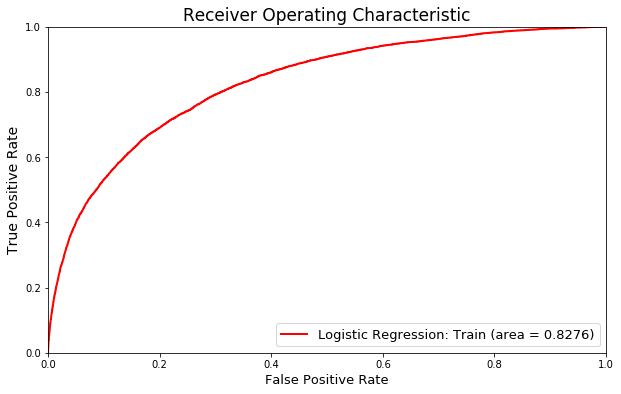

In [43]:
src.model_eval.evaluate_auc(logit, X_train, y_train, 'Logistic Regression: Train')

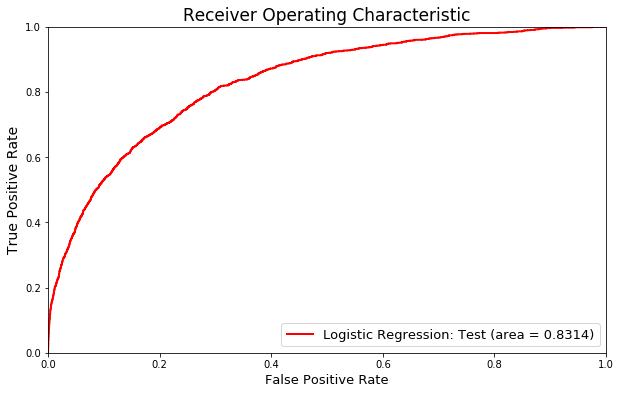

In [44]:
src.model_eval.evaluate_auc(logit, X_test, y_test, 'Logistic Regression: Test')

### Decision Tree

In [45]:
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Results on the Training Data:

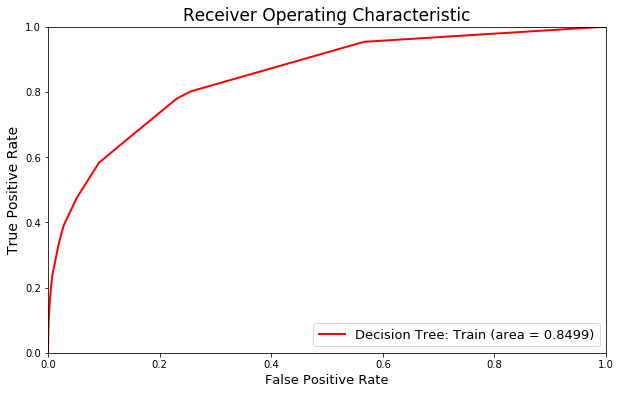

In [46]:
src.model_eval.evaluate_auc(tree, X_train, y_train, 'Decision Tree: Train')

Results on the Test Data:

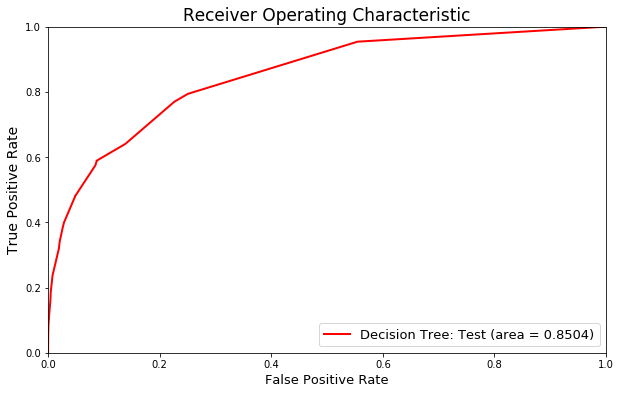

In [47]:
src.model_eval.evaluate_auc(tree, X_test, y_test, 'Decision Tree: Test')

**Identifying which features were the most impactful to the Decision Tree model:**

In [48]:
src.model_eval.get_feature_importance(X, tree.feature_importances_)

feature  importance
14      h1_arterial_ph_min    0.594082
13      h1_arterial_ph_max    0.159992
10       d1_hemaglobin_min     0.13022
3               d1_mbp_min    0.036145
1   d1_diasbp_invasive_min   0.0287705
4              d1_spo2_min   0.0135609
12           h1_sodium_max  0.00830863
9        d1_hemaglobin_max  0.00706927
0       urineoutput_apache   0.0050154
2            d1_diasbp_min  0.00475298
5      h1_mbp_invasive_max  0.00350503
7             h1_sysbp_min  0.00265784
6    h1_sysbp_invasive_max  0.00254593
8        d1_creatinine_min  0.00213998
11          h1_lactate_min  0.00123519

### Random Forest

In [49]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

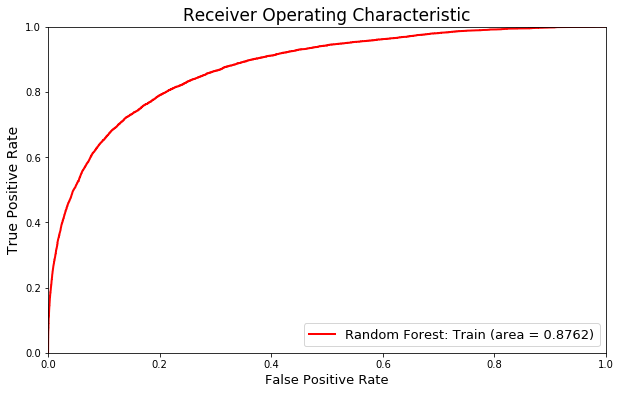

In [50]:
src.model_eval.evaluate_auc(forest, X_train, y_train, 'Random Forest: Train')

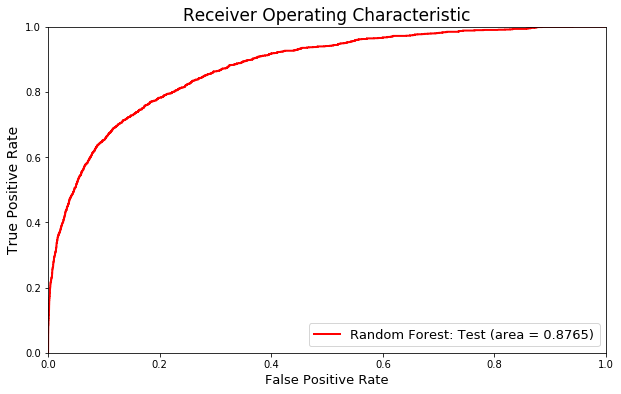

In [51]:
src.model_eval.evaluate_auc(forest, X_test, y_test, 'Random Forest: Test')

### XG Boost

In [52]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV

In [53]:
xgb = XGBClassifier(learning_rate =0.1, n_estimators=177, max_depth=7,
 min_child_weight=5, gamma=0.25, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, reg_alpha=0.0001, seed=27)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=177, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=27, reg_alpha=0.0001,
              reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

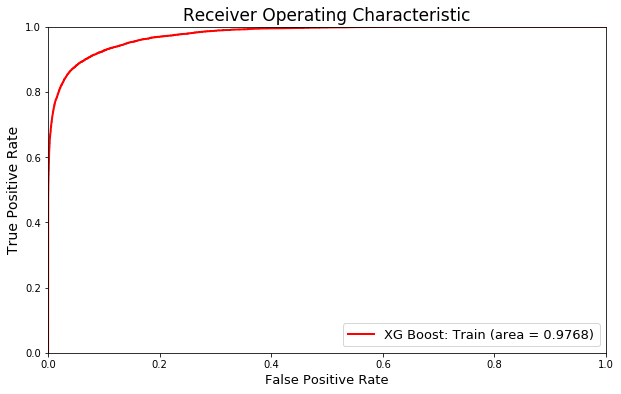

In [54]:
src.model_eval.evaluate_auc(xgb, X_train, y_train, 'XG Boost: Train')

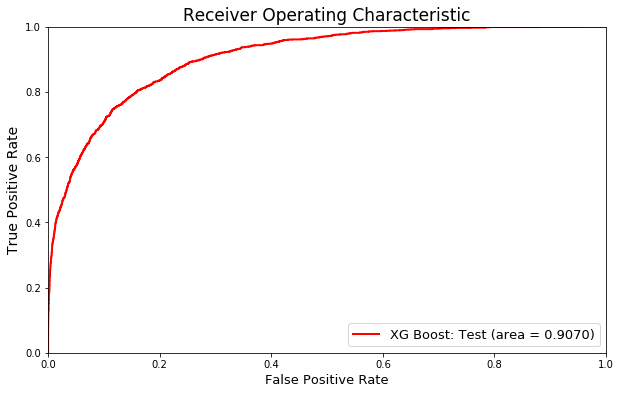

In [55]:
src.model_eval.evaluate_auc(xgb, X_test, y_test, 'XG Boost: Test')

### Light GBM

In [56]:
from lightgbm import LGBMClassifier

In [57]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 6
params['min_child_weight'] = 1
params['n_estimators'] = 350
clf = lgb.train(params, d_train, 350)

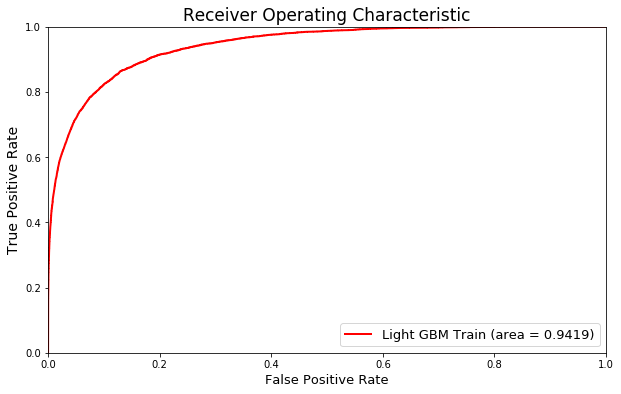

In [58]:
plt.figure(figsize=(10,6))

y_pred=clf.predict(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='Light GBM Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

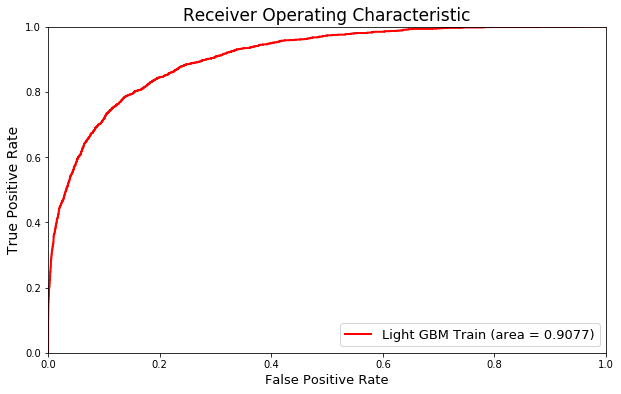

In [59]:
plt.figure(figsize=(10,6))

y_pred=clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='Light GBM Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

# Conclusion

Our project gave us insight into indentifying two key patient groups: patients who are at high risk of dying, and __patients who were at a low risk of dying yet still succumbed to their injuries__.

Let's use the best performing model, our __light GBM model__ to look at some examples of these two groups:

In [60]:
# Applying our Light GBM Model to our data
final_data = X_train
final_data['predicted_survival'] = clf.predict(X_train)
final_data['actual_patient_outcome'] = y_train

In [61]:
final_results = final_data[['actual_patient_outcome', 'predicted_survival']]

We'll be using final_results to look at a comparison between the actual patient outcome, and what our model predicted.
>__Keep in mind that the close to 1 for the prediction, the model predicted the patient was more likely not to survive__

## High Risk Patients 

In [62]:
above_80 = final_results.predicted_survival > .8
survived = final_results.actual_patient_outcome == 0
did_not_survive = final_results.actual_patient_outcome == 1

In [63]:
len(final_results[above_80]) / len(final_results)

0.015183317432192995

1 Percent of the patients in our data were predicted to have above an 80 percent chance of dying. Let's see how accurate the model was at predicting the outcomes for those it predicted above 80%:

In [64]:
len(final_results[above_80 & did_not_survive]) / len(final_results[above_80])

0.9838420107719928

So our model does a pretty good job of identifying high risk patients and accurately predicting they are unlikely to survive. __But what about those cases where the patient survived?__

In [65]:
len(final_results[above_80 & survived]) / len(final_results[above_80])

0.01615798922800718

## Patients With Low Probability of Dying who Didn't Survive

In [66]:
below_30 = final_results.predicted_survival < .3

In [67]:
len(final_results[below_30]) / len(final_results)

0.9187406296851575

91% of the patients were predicted to have a low risk of dying in the ICU. Let's see how many of those patients actually did not survive:

In [68]:
len(final_results[below_30 & did_not_survive]) / len(final_results[below_30])

0.03455079515784477

In [69]:
# Number of patients assessed to have less than a 30% chance of dying who did not survive
len(final_results[below_30 & did_not_survive])

2329